# MNIST Data Analysis

In [1]:
%%capture

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

import import_ipynb
import DataUtils as DU

import cache_magic # pip install ipython-cache

In [2]:
Ximg, Xlab = DU.load_data("data/mnist_70000.h5")

## Raw Data

MNIST is a dataset of 70,000 handwritten digit images, each normalized to fit within a 28x28 array.

Digits are written by different subjects, thus there is considerable variation in the way that digits are formed.

Here is a sample of the digits found in MNIST:

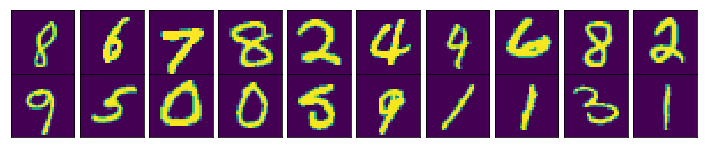

In [3]:
DU.show_data(Ximg[:20], cols=10)

## Principal Components

We perform singular value decomposition of the covariance matrix to determine the principal components of the data.

### Explanation of variance

The following graph shows the relative magnitude of each principal component, and how much total variance is explained by the first $k$ principal components.


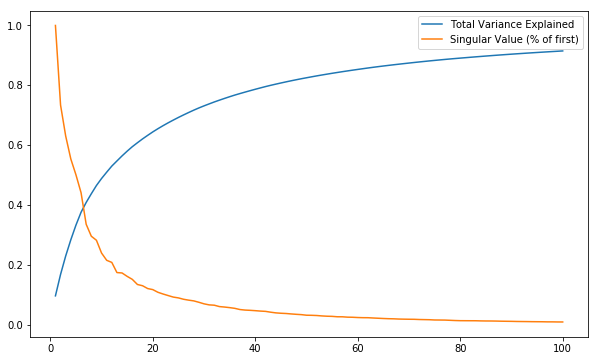

In [4]:
X, Xbar, CX = DU.normalize_image_data(Ximg)
Xu, Xs, Xvt = np.linalg.svd(CX)
DU.graph_variance_explained(Xs)

### Visualizing Principal Components

We can interpret the meaning of each principal component by projecting it as an image.

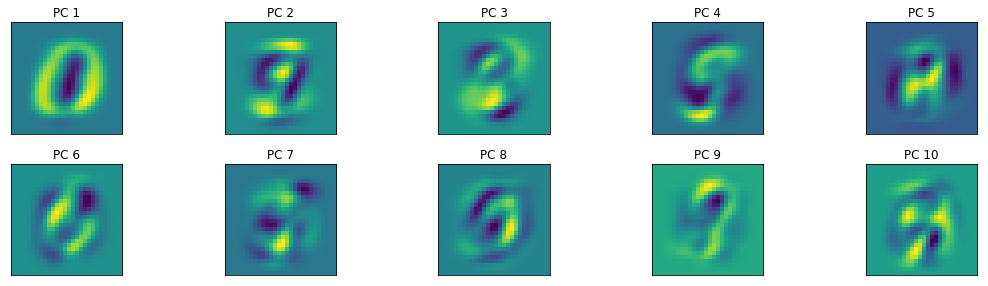

In [5]:
DU.show_pcs(Xu, 10)

The graph above shows the first 10 principal components.

* The first principal component (PC 1) differentiates between the images `0` and `1`.
* Other PCs appear to include recognizable features of digits `9`, `3`, and `6`.
* As further principal components are visualized, the apparent complexity of their respective images increases.

## Determining the Subspace

We can attempt to visually estimate the dimension of the linear subspace for MNIST data by looking at dimensionally reduced images projected back into pixel space.

Here, we examine the quality of 20 random digits as they are projected into truncated PCA coordianates.

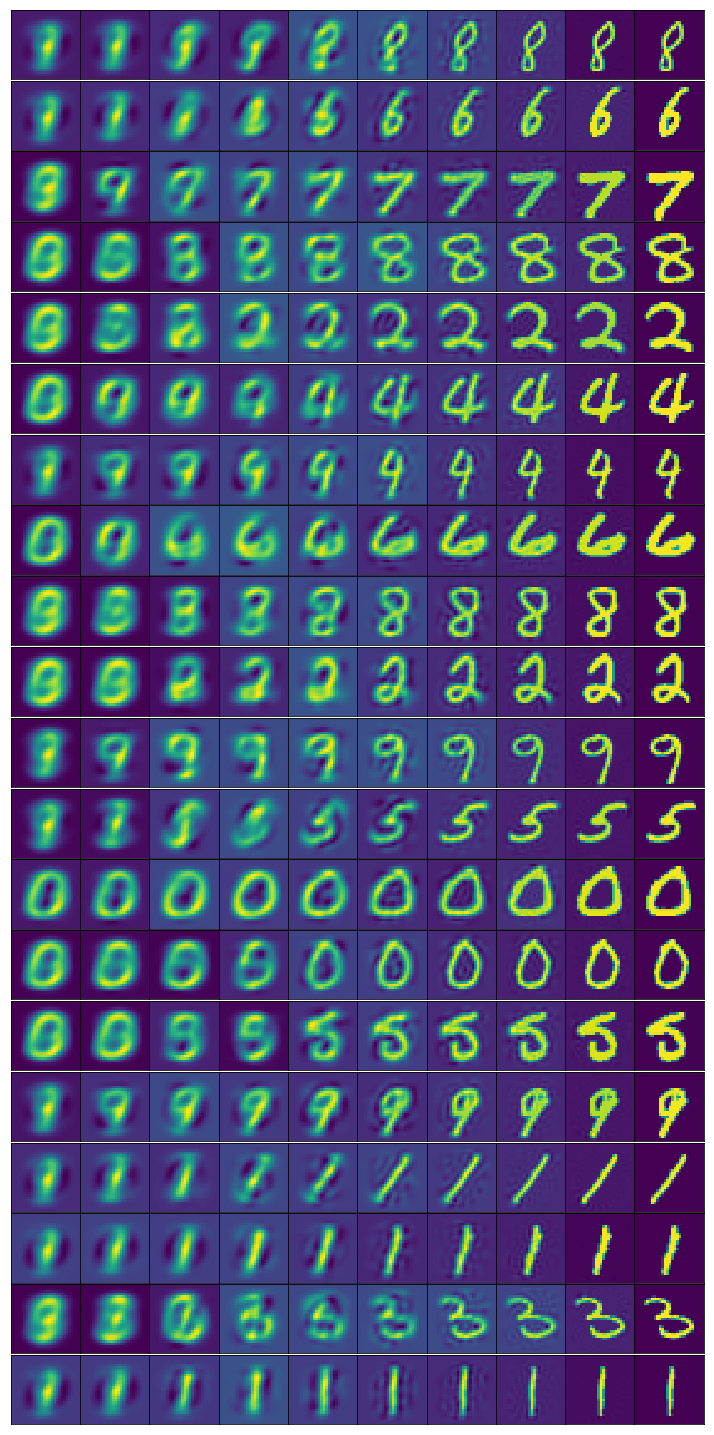

In [6]:
dims = [1, 2, 5, 10, 20, 50, 100, 200, 400, 784]

samp = X[:20]
Psamp = [(samp @ Xu[:,:k]) @ Xu.T[:k,:] for k in dims]

pcadigits = np.asarray(Psamp).transpose((1,0,2))

DU.show_data(np.vstack(pcadigits) + Xbar, cols=10)

In the image above, each row represents an original data point, and each column represents a level of PCA dimension reduction.





## Observations

We can characterize the number of PCA components used roughly as follows:

| Dimension | % Variance | Description                                   |
| --------- | ---------- | --------------------------------------------- |
| 1         | 10%        | digits resolve as 0 or 1                      |
| 10        | 40%        | basic forms become recognizable               |
| 20        | 60%        | most digits are recognizable                  |
| 50        | 80%        | all digits are easily recognizable            |
| 51-100    | > 80%      | edges sharpen as more components are added    |


## Isomap Embeddings

We compare the Isomap embeddings of the data when projected into the first $k$ principal components.

Due to slow runtimes for Isomap on large datasets, we limit the number of points to `20,000`.

In [7]:
nsamp = 20000
Xsamp = X[:nsamp]
%cache isomap_mnist_pca5 = DU.isomap_embedding(Xsamp @ Xu[:,:5])
%cache isomap_mnist_pca10 = DU.isomap_embedding(Xsamp @ Xu[:,:10])
%cache isomap_mnist_pca20 = DU.isomap_embedding(Xsamp @ Xu[:,:20])
%cache isomap_mnist_pca50 = DU.isomap_embedding(Xsamp @ Xu[:,:50])
%cache isomap_mnist_pca100 = DU.isomap_embedding(Xsamp @ Xu[:,:100])
%cache isomap_mnist_all = DU.isomap_embedding(Xsamp)

loading cached value for variable 'isomap_mnist_pca5'. Time since pickling  3:02:13.455849
loading cached value for variable 'isomap_mnist_pca10'. Time since pickling  2:56:00.314018
loading cached value for variable 'isomap_mnist_pca20'. Time since pickling  2:49:33.538159
loading cached value for variable 'isomap_mnist_pca50'. Time since pickling  2:42:24.726903
loading cached value for variable 'isomap_mnist_pca100'. Time since pickling  2:34:36.559971
loading cached value for variable 'isomap_mnist_all'. Time since pickling  2:20:44.148242


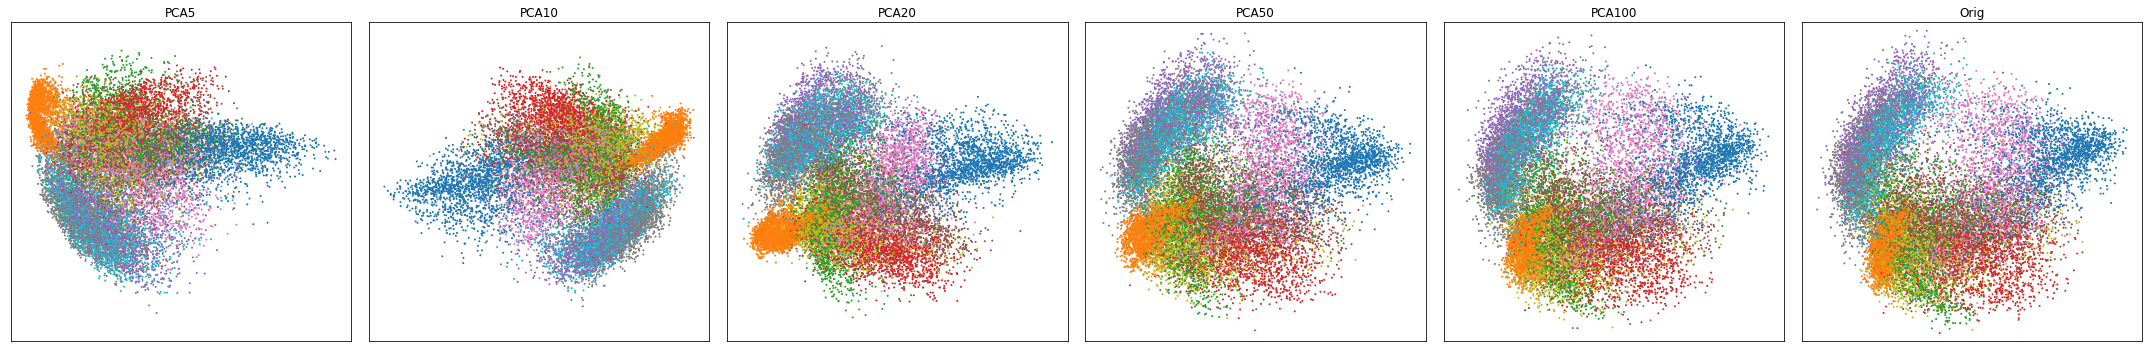

In [8]:
DU.show_embeddings(
    [isomap_mnist_pca5, isomap_mnist_pca10, isomap_mnist_pca20, isomap_mnist_pca50, isomap_mnist_pca100, isomap_mnist_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Xlab[:nsamp]
)

There is little variation across the images provided.  This, combined with the large clouds of overlapping points, suggests that Isomap is not capable representing the manifold in a way which clusters the MNIST digits.

## Modified Locally Linear Embedding (Modified LLE)

Next, we look at PCA projections of the data using LLE.

As with Isomap, we will restrict the data to `20,000` samples to reduce runtime.

In [9]:
%cache mlle_mnist_pca5 = DU.mlle_embedding(Xsamp @ Xu[:,:5])
%cache mlle_mnist_pca10 = DU.mlle_embedding(Xsamp @ Xu[:,:10])
%cache mlle_mnist_pca20 = DU.mlle_embedding(Xsamp @ Xu[:,:20])
%cache mlle_mnist_pca50 = DU.mlle_embedding(Xsamp @ Xu[:,:50])
%cache mlle_mnist_pca100 = DU.mlle_embedding(Xsamp @ Xu[:,:100])
%cache mlle_mnist_all = DU.mlle_embedding(Xsamp)

loading cached value for variable 'mlle_mnist_pca5'. Time since pickling  1:49:36.872496
loading cached value for variable 'mlle_mnist_pca10'. Time since pickling  1:43:39.851277
loading cached value for variable 'mlle_mnist_pca20'. Time since pickling  1:38:13.431762
loading cached value for variable 'mlle_mnist_pca50'. Time since pickling  1:31:12.995852
loading cached value for variable 'mlle_mnist_pca100'. Time since pickling  1:23:11.053620
loading cached value for variable 'mlle_mnist_all'. Time since pickling  1:07:59.173249


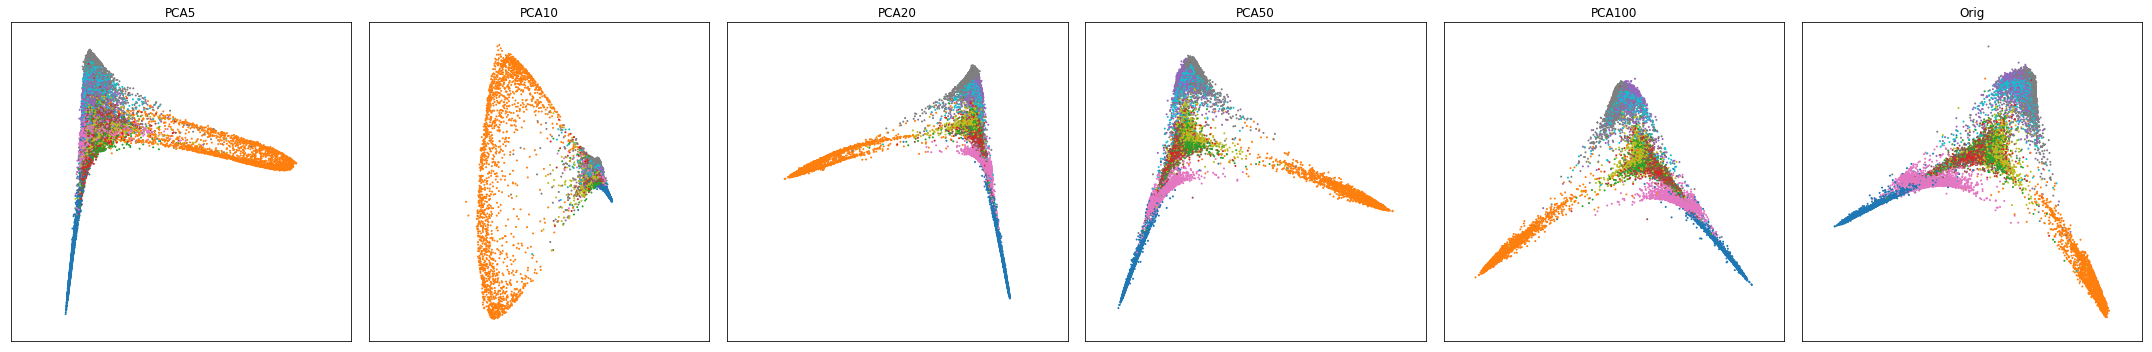

In [10]:
DU.show_embeddings(
    [mlle_mnist_pca5, mlle_mnist_pca10, mlle_mnist_pca20, mlle_mnist_pca50, mlle_mnist_pca100, mlle_mnist_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Xlab[:nsamp]
)

Modified LLE produces similar embeddings when using 20 or more dimensions.  Although the shape of the embedding is crowded, and does not make efficient use of screen real estate, we can see that several of the MNIST digits are organized into separate areas, with some shared boundaries and overlap.

## Uniform Manifold Approximation and Projection (UMAP)

Here, we look at same PCA projections of the data using UMAP.

In [11]:
%cache umap_mnist_pca5 = DU.umap_embedding(X @ Xu[:,:5])
%cache umap_mnist_pca10 = DU.umap_embedding(X @ Xu[:,:10])
%cache umap_mnist_pca20 = DU.umap_embedding(X @ Xu[:,:20])
%cache umap_mnist_pca50 = DU.umap_embedding(X @ Xu[:,:50])
%cache umap_mnist_pca100 = DU.umap_embedding(X @ Xu[:,:100])
%cache umap_mnist_all = DU.umap_embedding(X)

loading cached value for variable 'umap_mnist_pca5'. Time since pickling  3:42:29.317586
loading cached value for variable 'umap_mnist_pca10'. Time since pickling  3:41:25.086074
loading cached value for variable 'umap_mnist_pca20'. Time since pickling  3:40:19.340060
loading cached value for variable 'umap_mnist_pca50'. Time since pickling  3:39:12.198137
loading cached value for variable 'umap_mnist_pca100'. Time since pickling  3:38:03.563801
loading cached value for variable 'umap_mnist_all'. Time since pickling  3:36:44.606503


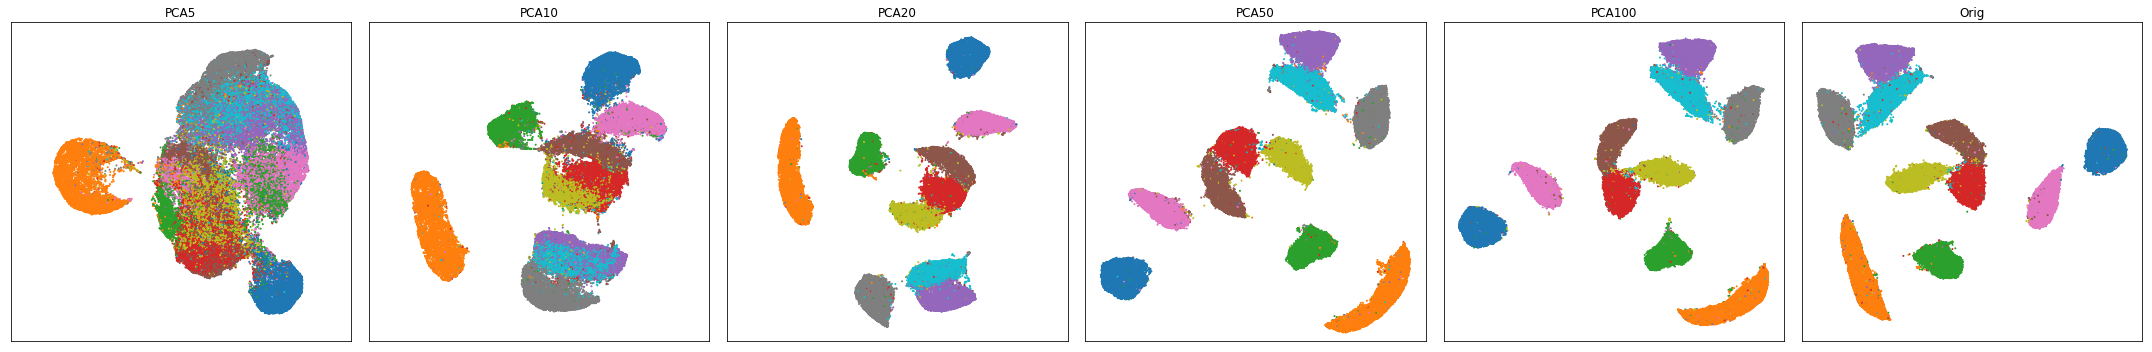

In [12]:
DU.show_embeddings(
    [umap_mnist_pca5, umap_mnist_pca10, umap_mnist_pca20, umap_mnist_pca50, umap_mnist_pca100, umap_mnist_all],
    titles=["PCA5", "PCA10", "PCA20", "PCA50", "PCA100", "Orig"],
    labels=Xlab
)

The UMAP embeddings appear to do the best job of representing the manifold in two dimensions.  Based on the compactness and separation of visible clusters, UMAP validates our earlier understanding of the manifold and subspace.

## Conclusion

MNIST has an underlying manifold which reveals clusters for each of the separate digits.  To an acceptable degree of approximation, this manifold lies in a **50-D subspace**.


In [13]:
%cache

var name,size(byte),stored at date,time(s),version,expression(hash)
mlle_mnist_all,320161,2018-11-23 18:48:34.657170,911.9,DU.mlle_embedding(Xsamp),DU.mlle_embedding(Xsamp)
umap_mnist_pca100,560163,2018-11-23 16:18:34.954534,68.6,"DU.umap_embedding((X @ Xu[:, :100]))","DU.umap_embedding((X @ Xu[:, :100]))"
isomap_mnist_pca10,320161,2018-11-23 17:00:28.554450,373.1,"DU.isomap_embedding((Xsamp @ Xu[:, :10]))","DU.isomap_embedding((Xsamp @ Xu[:, :10]))"
isomap_mnist_pca100,320161,2018-11-23 17:21:52.311614,468.1,"DU.isomap_embedding((Xsamp @ Xu[:, :100]))","DU.isomap_embedding((Xsamp @ Xu[:, :100]))"
isomap_mnist_pca20,320161,2018-11-23 17:06:55.331370,386.7,"DU.isomap_embedding((Xsamp @ Xu[:, :20]))","DU.isomap_embedding((Xsamp @ Xu[:, :20]))"
isomap_mnist_pca50,320161,2018-11-23 17:14:04.143749,428.8,"DU.isomap_embedding((Xsamp @ Xu[:, :50]))","DU.isomap_embedding((Xsamp @ Xu[:, :50]))"
isomap_mnist_all,320161,2018-11-23 17:35:44.724150,832.4,DU.isomap_embedding(Xsamp),DU.isomap_embedding(Xsamp)
isomap_mnist_pca5,320161,2018-11-23 16:54:15.411479,366.6,"DU.isomap_embedding((Xsamp @ Xu[:, :5]))","DU.isomap_embedding((Xsamp @ Xu[:, :5]))"
mlle_mnist_pca50,320161,2018-11-23 18:25:20.832954,420.4,"DU.mlle_embedding((Xsamp @ Xu[:, :50]))","DU.mlle_embedding((Xsamp @ Xu[:, :50]))"
umap_mnist_pca5,560163,2018-11-23 16:14:09.195855,67.1,"DU.umap_embedding((X @ Xu[:, :5]))","DU.umap_embedding((X @ Xu[:, :5]))"
